<a href="https://colab.research.google.com/github/incheonQ/AIFFEL_quest_cr/blob/main/Keras/tensorflow_flower_dataset_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 셋업

In [1]:
!pip install keras_cv
import keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 31.6 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
tf.__version__

'2.17.1'

In [4]:
import tensorflow_datasets as tfds

tfds.__version__

'4.9.7'

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [25]:
from tensorflow.keras.regularizers import l1

# 데이터셋 준비

In [6]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
        name='tf_flowers',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        as_supervised=True,
        with_info=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
print("훈련 데이터셋 크기:", len(raw_train))
print("검증 데이터셋 크기:", len(raw_validation))
print("테스트 데이터셋 크기:", len(raw_test))

훈련 데이터셋 크기: 2936
검증 데이터셋 크기: 367
테스트 데이터셋 크기: 367


In [8]:
num_classes = metadata.features['label'].num_classes
num_classes

5

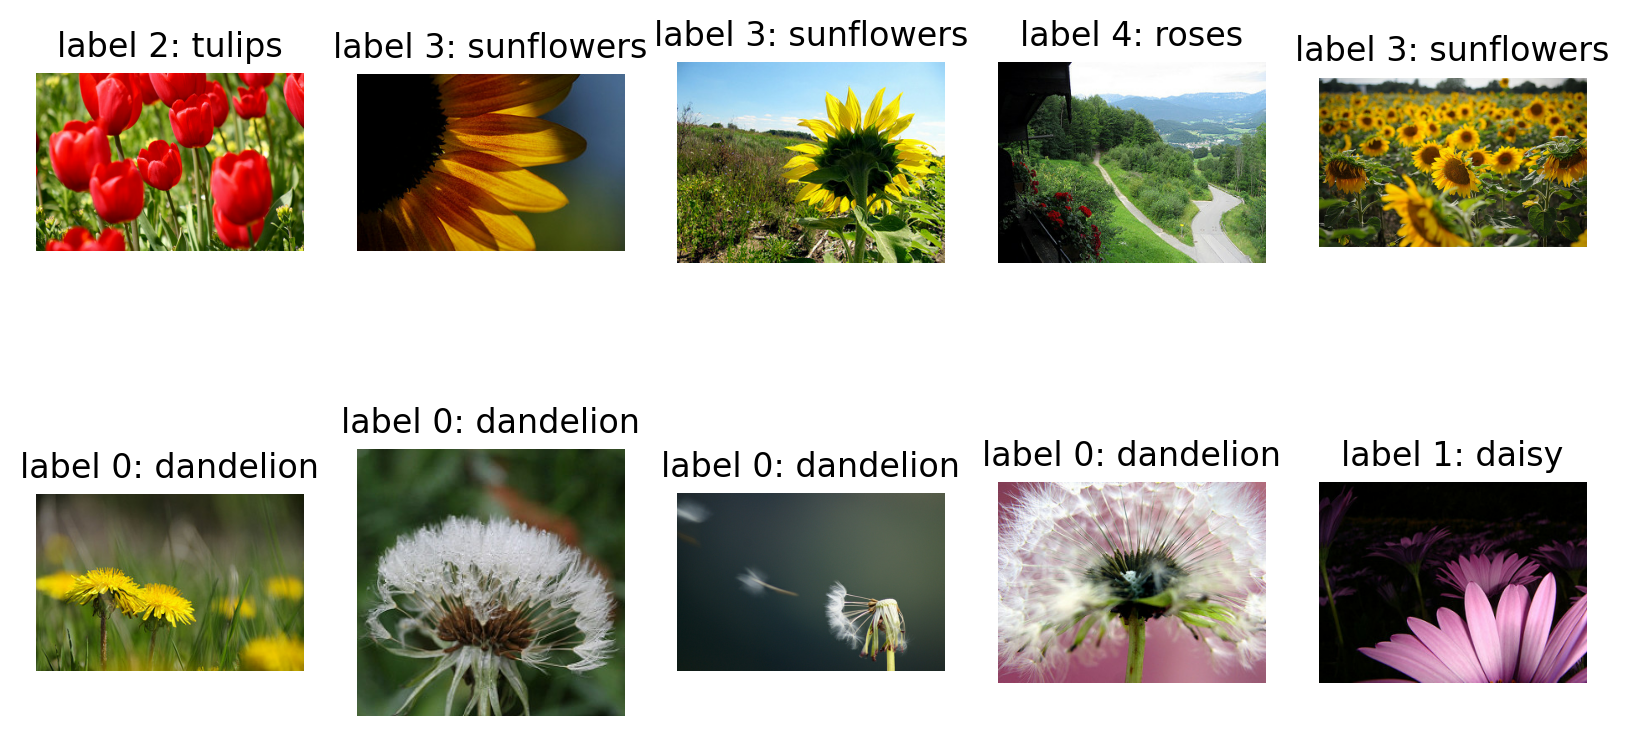

In [9]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [10]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


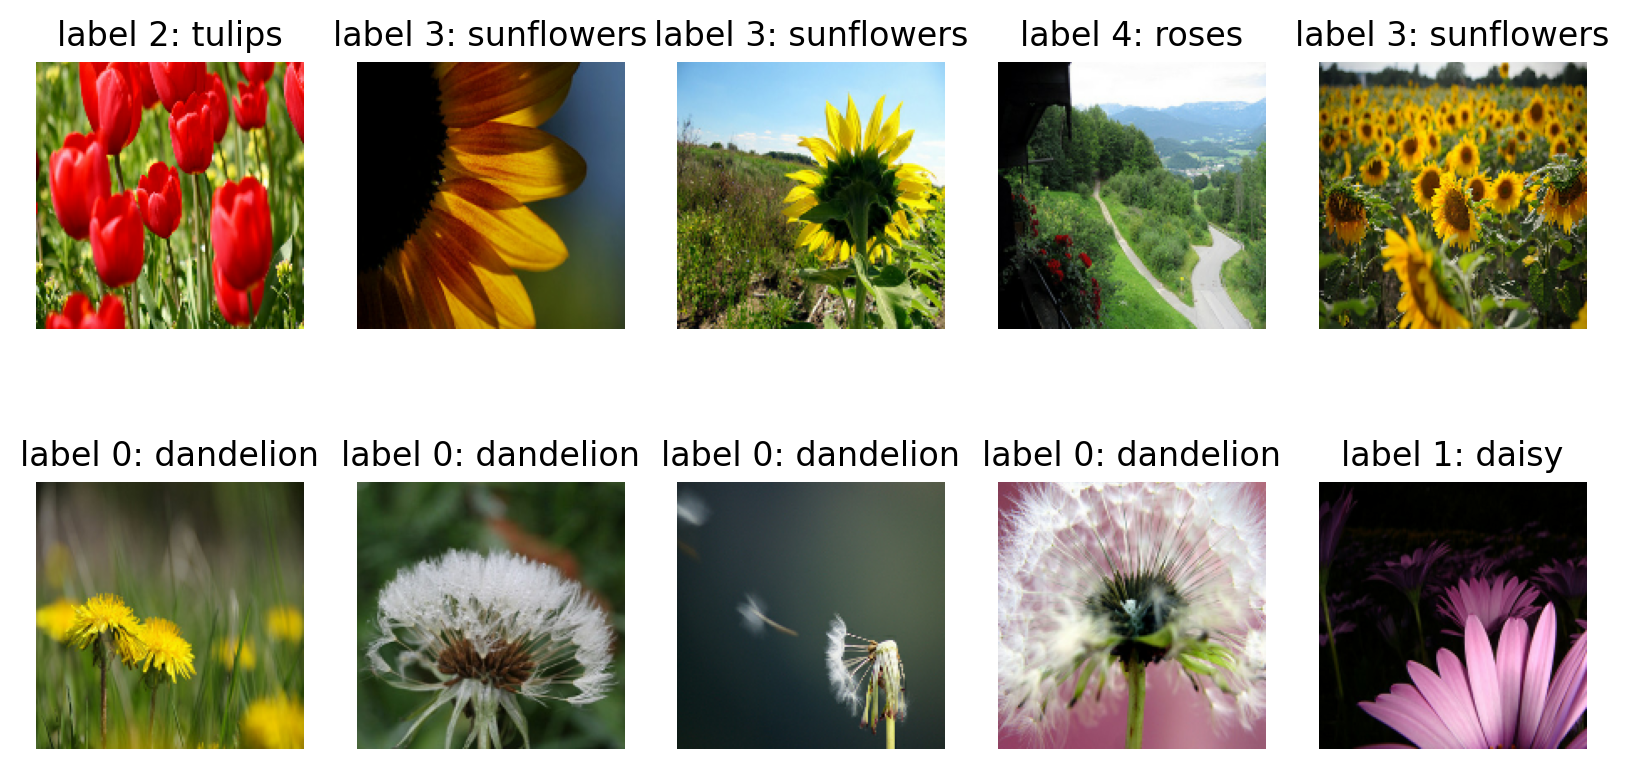

In [11]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

# 모델링

In [96]:
# base model : VGG16
base_model = tf.keras.applications.VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# GAP (Global Average Pooling)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# BatchNormalization
batch_normalization_layer = tf.keras.layers.BatchNormalization()

# Dense
dense_layer_1 = tf.keras.layers.Dense(units=512, activation='gelu', kernel_regularizer=l1(l1=0.001)) # kernel_regularizer=l1(l1=0.001)
dense_layer_2 = tf.keras.layers.Dense(units=512, activation='gelu', kernel_regularizer=l1(l1=0.001))
dense_layer_3 = tf.keras.layers.Dense(units=512, activation='gelu', kernel_regularizer=l1(l1=0.001))

# Dropout
dropout_layer = tf.keras.layers.Dropout(0.2)

# Binary classification
prediction_layer = tf.keras.layers.Dense(units=num_classes, activation='softmax')

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  batch_normalization_layer,
  dense_layer_1,
  dense_layer_2,
  dense_layer_3,
  dropout_layer,
  prediction_layer
])

In [97]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 5, 5, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,507,269 (59.16 MB)

 Trainable params: 791,557 (3.02 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

# 데이터 증강

In [98]:
# 라벨 원핫인코딩 함수 정의
def one_hot_encode(image, label):
    # tf_flowers는 5개 클래스(0-4)를 가지므로 depth=5로 설정
    label = tf.one_hot(label, depth=5)
    return image, label

# 데이터셋에 원핫인코딩 적용
train_onehot = train.map(one_hot_encode)
validation_onehot = validation.map(one_hot_encode)
test_onehot = test.map(one_hot_encode)

In [99]:
def create_augmentation_pipeline():
    # RandAugment, CutMix, MixUp 설정
    rand_augment = keras_cv.layers.RandAugment(
        value_range=(-1, 1),
        augmentations_per_image=2, # 14개의 변환 중 랜덤하게 3개 선택
        magnitude=0.2              # 변환 강도
    )
    # cut_mix = keras_cv.layers.CutMix()
    # mix_up = keras_cv.layers.MixUp()

    def augment(images, labels):
        # RandAugment 적용
        images = rand_augment(images)

        # # 이미지를 float32로 변환
        # images = tf.cast(images, tf.float32)

        # # labels를 float32로 변환
        # labels = tf.cast(labels, tf.float32)

        # # CutMix와 MixUp 적용
        augmented = {"images": images, "labels": labels}
        # augmented = cut_mix(augmented)
        # augmented = mix_up(augmented)

        return augmented["images"], augmented["labels"]

    return augment

In [100]:
BATCH_SIZE = 64

# 훈련 데이터셋 생성 (augmentation 포함)
train_batches = (
    train_onehot
    .batch(BATCH_SIZE)
    .map(create_augmentation_pipeline(), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

# 검증 데이터셋 생성
val_batches = (
    validation_onehot
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# 테스트 데이터셋 생성
test_batches = (
    test_onehot
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# 모델 학습

In [101]:
LEARNING_RATE = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [102]:
# 콜백 함수
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'best_model_{BATCH_SIZE}_{LEARNING_RATE}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1
    )
]

In [103]:
EPOCHS = 100
with tf.device('/gpu:0'):
  history = model.fit(train_batches,
                      epochs=EPOCHS,
                      validation_data=val_batches,
                      callbacks = callbacks)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5885 - loss: 26.5613
Epoch 1: val_accuracy improved from -inf to 0.55858, saving model to best_model_64_0.001.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.5904 - loss: 26.4639 - val_accuracy: 0.5586 - val_loss: 13.9625 - learning_rate: 0.0010
Epoch 2/100
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7859 - loss: 10.4655
Epoch 2: val_accuracy improved from 0.55858 to 0.71117, saving model to best_model_64_0.001.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7862 - loss: 10.3065 - val_accuracy: 0.7112 - val_loss: 4.6472 - learning_rate: 0.0010
Epoch 3/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7881 - loss: 3.3203
Epoch 3: val_accuracy improved from 0.71117 to 0.77112, saving model to best_model_64_0.001.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7880 - loss: 3.2961 - val_accuracy: 0.7711 - val_loss: 2.3476 - learning_rate: 0.0010
Epoch 4/100
45/46 ━━━━━

# 모델 성능 평가

In [107]:
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"Test Accuracy: {np.mean(test_accuracy)*100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8561 - loss: 0.7550
Test Accuracy: 86.92%


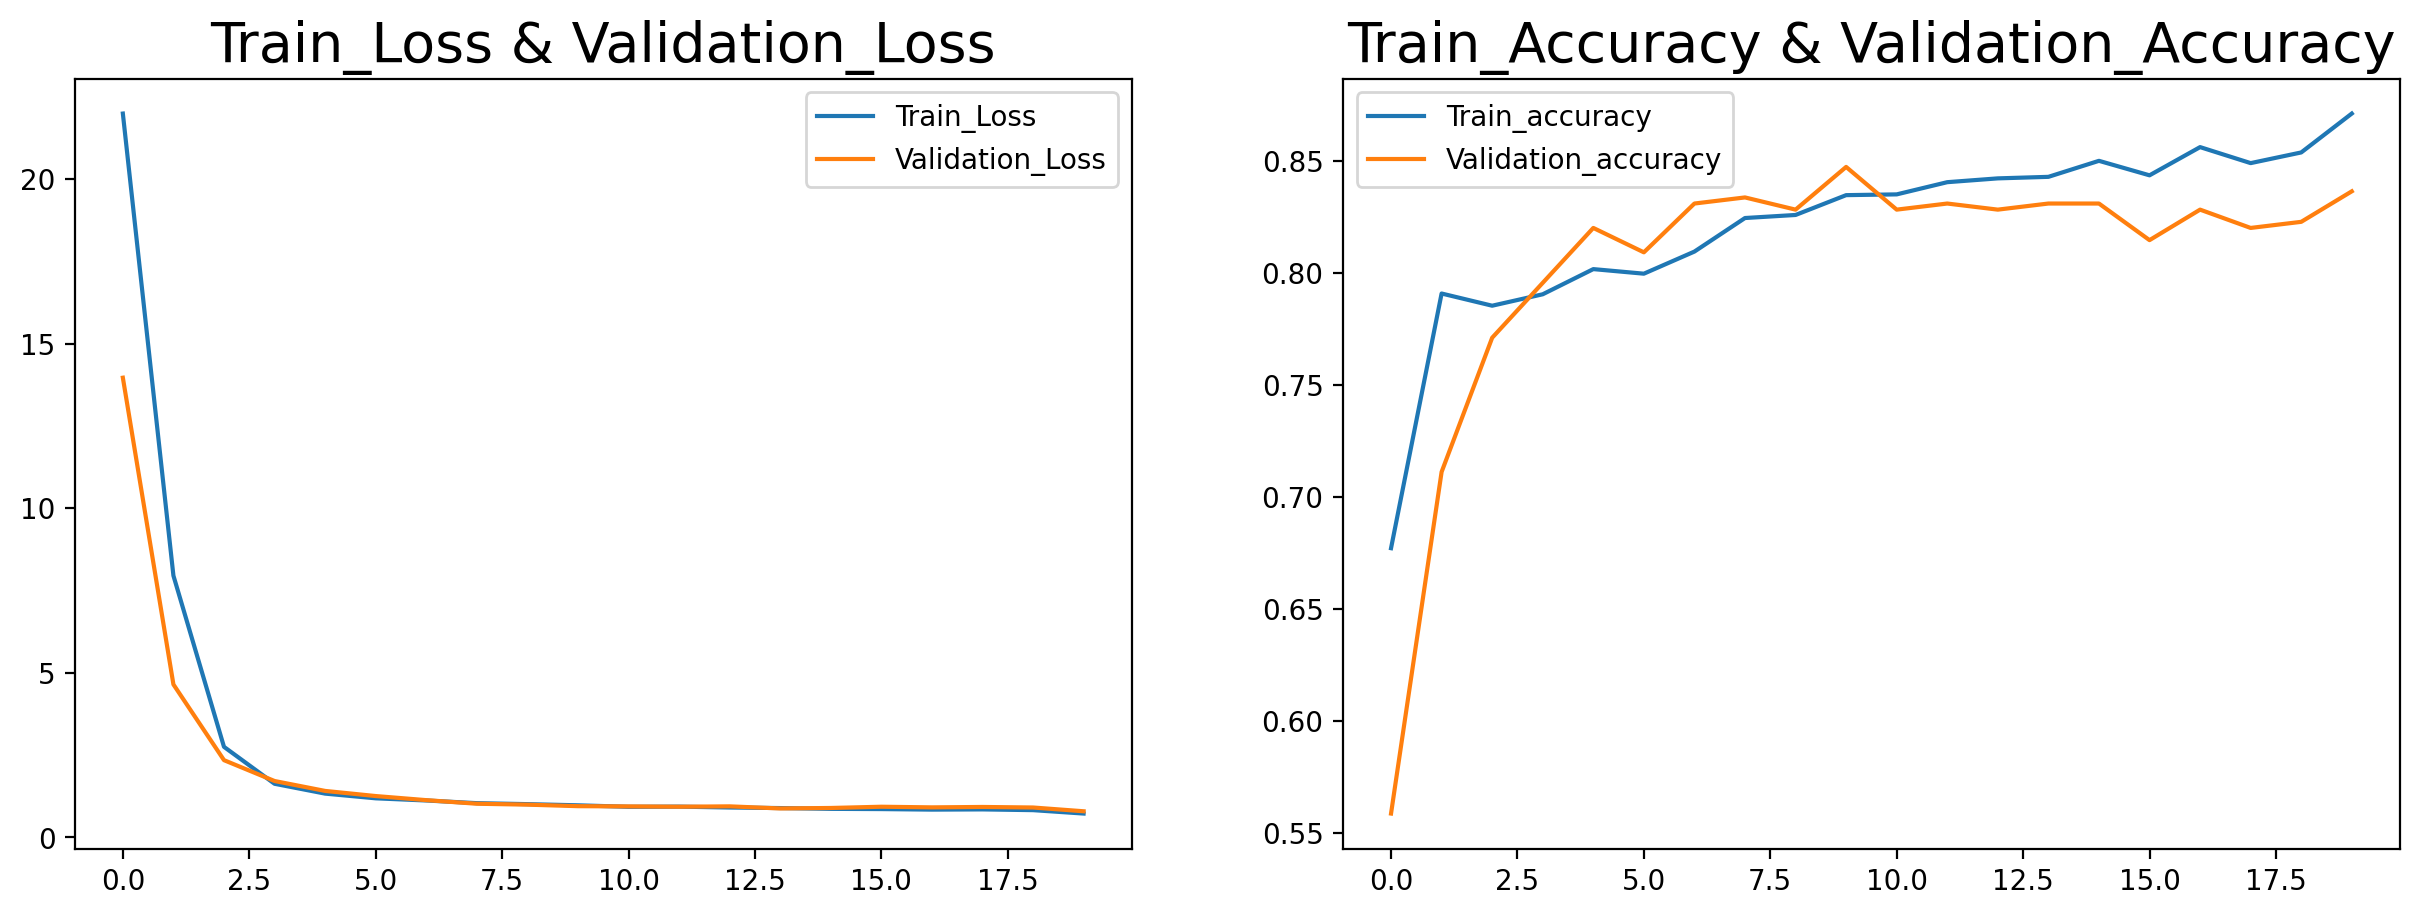

In [105]:
plt.figure(figsize=(15,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train_Loss')
plt.plot(history.history['val_loss'], label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss', fontsize=20)
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train_accuracy')
plt.plot(history.history['val_accuracy'], label='Validation_accuracy')
plt.title('Train_Accuracy & Validation_Accuracy', fontsize=20)
plt.legend()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

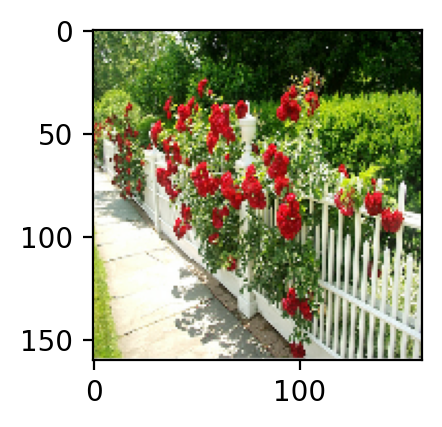

In [106]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    predictions = np.argmax(predictions, axis=1)

plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

# 모델 활용

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    dog_percentage = round(prediction[1] * 100)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")

In [ ]:
img_dir_path = '/content'
filename = '화면 캡처 2024-11-21 124547.jpg'

show_and_predict_image(img_dir_path, filename)